# Costco Stores Growth Potential Prediction

Costco is rapidly growing U.S. Warehouse chain store that have been getting more and more popularity as well as business success. This project is to predict their growth potentials by analyzing the existing Costco stores to generate similar future store locations within any given U.S. State so that Costco can grow there to reach its potentials. 

Of course there are many ways for Costco to grow. In the interests of this project, data science and machine learning are in place to locate current Costso warehouse store city information to find similar city within a given State. The city information includes population, family size, median household income and other factors. K-Nearest Neighbors (KNN) algorithm is used to make recommendations of the future store locations for a given State.




### Current Existing Costco Warehouse Location

#### https://github.com/swinton/Visualize-This/blob/master/ch08/geocode/costcos-limited.csv


In [19]:
import numpy as np
import pandas as pd

locations = pd.read_csv("Costco-locations.csv", encoding = 'ISO-8859-1')

locations['City'] = locations['City'].str.strip()
locations['State'] = locations['State'].str.strip()

print(locations.shape)
locations.head()

(417, 5)


,Warehouse Number,Address,City,State,Zip Code
0,356,1205 N. Memorial Parkway,Huntsville,Alabama,35801-5930
1,362,3650 Galleria Circle,Hoover,Alabama,35244-2346
2,1009,8251 Eastchase Parkway,Montgomery,Alabama,36117
3,107,5225 Commercial Boulevard,Juneau,Alaska,99801-7210
4,10,330 West Dimond Blvd,Anchorage,Alaska,99515-1950


## Location Selection Category

The best location selection would be based on the financial data of each existing Costco warehouse store sales revenue. However due to the limitation of accessing this dataset, an assumption has been made here to leverage the existing stores as "selected", and other cities in U.S. as "not-selected" for clustering categorization differentiation.

Further on, to help break down the number of "selected" stores into more classes, another assumption is made to use the timing when these stores were opened to be the differences of the classes:

    0 - city has no Costco stores

    1 - city that has Costco stores opened 5 years ago

    2 - city that has Costco stores openned 2 years ago

    3 - city that has Costco stores openned less than 2 years

Store opening timing data are collected from https://www.winsightgrocerybusiness.com/retailers/heres-where-costco-opening-2019 and https://www.savingadvice.com/articles/2019/01/08/1052240_new-costco-locations-2018.html

In [20]:
costco_labels = pd.read_csv('Costco-labels.csv', header=None)
costco_labels.columns = ['City', 'State', 'Category']

location_labels = pd.merge(locations, costco_labels, on=['City', 'State'], how = 'outer')

location_labels.loc[location_labels.Category.isnull(), 'Category'] = 1

print(location_labels.shape)
location_labels.head()

(456, 6)


,Warehouse Number,Address,City,State,Zip Code,Category
0,356.0,1205 N. Memorial Parkway,Huntsville,Alabama,35801-5930,1.0
1,362.0,3650 Galleria Circle,Hoover,Alabama,35244-2346,1.0
2,1009.0,8251 Eastchase Parkway,Montgomery,Alabama,36117,1.0
3,107.0,5225 Commercial Boulevard,Juneau,Alaska,99801-7210,1.0
4,10.0,330 West Dimond Blvd,Anchorage,Alaska,99515-1950,1.0


## Top U.S. Cities with Population and Growth

We are looking for a list of potential cities to make recommendation as the next store. One feature is the Population, another feature is the Growth. The assumptions are to find similar stores - basically evaluate the existing stores on both pupulations and growth to measure the similarity under clustering and grouping.

### https://www.biggestuscities.com/



In [21]:
import requests
from bs4 import BeautifulSoup

page = requests.get("https://www.biggestuscities.com/")
soup = BeautifulSoup(page.content, 'html.parser')

all_cities_tags = soup.find_all('tr')

In [22]:

city_list = []
header = True

for city_item in all_cities_tags:
    
    # skip the first header line
    if (header == True):
        header = False
        continue
    
    elements = city_item.find_all('td')
    
    if (len(elements) > 2):
        city_no = elements[0].get_text().strip()
        city_name = elements[1].get_text().strip()
        state = elements[2].get_text().strip()
        population = elements[3].get_text().strip().replace(',', '')
    
    #print(city_no, city_name, state, population)
    city_list.append((city_no, city_name, state, population))
                         
us_cities = pd.DataFrame(city_list, columns=['Rank', 'City', 'State', 'Population_Size'])
us_cities.head()
    

,Rank,City,State,Population_Size
0,1,New York,New York,8622698
1,2,Los Angeles,California,3999759
2,3,Chicago,Illinois,2716450
3,4,Houston,Texas,2312717
4,5,Phoenix,Arizona,1626078


In [23]:
# add the feature column
print(location_labels.shape, us_cities.shape)
costco_locations = pd.merge(location_labels, us_cities, on = ['City', 'State'], how='left')
costco_locations = costco_locations[['City', 'State', 'Category', 'Population_Size']]

#costco_locations.loc[costco_locations.Population_Size.isnull(), 'Population_Size'] = 0
costco_locations.loc[costco_locations.Category.isnull(), 'Category'] = 0

#costco_locations['Population_Size'] = (costco_locations['Population_Size']).astype(int)
                                     
print(costco_locations.shape)
costco_locations.head()


((456, 6), (1003, 4))
(456, 4)


,City,State,Category,Population_Size
0,Huntsville,Alabama,1.0,194585
1,Hoover,Alabama,1.0,84920
2,Montgomery,Alabama,1.0,199518
3,Juneau,Alaska,1.0,NaN
4,Anchorage,Alaska,1.0,294356


### Population Data Check

In [34]:
# Check the number of cities that have no population data
missing_population_cities = costco_locations[costco_locations.Population_Size.isnull() == True]
print(missing_population_cities.shape)

(183, 4)


From the 456 cities that Costco has store, 183 of them does not have population data in this dataset! This population dataset is unusable. We need to find the population from other data source.

## Census Data API with Income and Household Info

US Census provides rich but raw data for american household information, including median family income, number of vehicles, number of family members. The following steps are to extract data, clean and run aggregation to prepare for better format.

To download the US Census data, visit https://data2.nhgis.org to select specific data around U.S. places (including cities, town, village, etc). The data will be downloaded through csv file for further processing.

In [24]:
census_place_all = pd.read_csv('nhgis0001_ds177_20105_2010_place.csv', encoding = 'ISO-8859-1')
census_place_all.head()

,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTYA,COUSUBA,PLACE,PLACEA,TRACTA,CONCITA,AIANHHA,RES_ONLYA,TRUSTA,AITSCEA,ANRCA,CBSAA,CSAA,METDIVA,NECTAA,CNECTAA,NECTADIVA,UAA,CDCURRA,SLDUA,SLDLA,SUBMCDA,SDELMA,SDSECA,SDUNIA,PUMA5A,BTTRA,NAME_E,JZVE001,JZVE002,JZVE003,JZVE004,JZVE005,JZVE006,JZVE007,JZVE008,JZVE009,JZVE010,JZVE011,JZVE012,JZVE013,JZVE014,JZVE015,JZVE016,JZVE017,JZVE018,JZVE019,JZVE020,JZVE021,JZVE022,JZVE023,JZVE024,JZVE025,JZVE026,JZVE027,JZVE028,JZVE029,JZVE030,JZWE001,JZWE002,JZWE003,JZWE004,JZWE005,JZWE006,JZWE007,JZWE008,JZWE009,JZWE010,JZWE011,JZWE012,JZWE013,JZWE014,JZWE015,JZWE016,JZWE017,JZWE018,JZWE019,JZWE020,JZWE021,JZWE022,J4FE001,J4FE002,J4FE003,J4FE004,J4FE005,J4FE006,J4FE007,J4FE008,NAME_M,JZVM001,JZVM002,JZVM003,JZVM004,JZVM005,JZVM006,JZVM007,JZVM008,JZVM009,JZVM010,JZVM011,JZVM012,JZVM013,JZVM014,JZVM015,JZVM016,JZVM017,JZVM018,JZVM019,JZVM020,JZVM021,JZVM022,JZVM023,JZVM024,JZVM025,JZVM026,JZVM027,JZVM028,JZVM029,JZVM030,JZWM001,JZWM002,JZWM003,JZWM004,JZWM005,JZWM006,JZWM007,JZWM008,JZWM009,JZWM010,JZWM011,JZWM012,JZWM013,JZWM014,JZWM015,JZWM016,JZWM017,JZWM018,JZWM019,JZWM020,JZWM021,JZWM022,J4FM001,J4FM002,J4FM003,J4FM004,J4FM005,J4FM006,J4FM007,J4FM008
0,G01000100,2006-2010,NaN,NaN,Alabama,1,NaN,NaN,Abanda CDP,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Abanda CDP, Alabama",32,0,10,22,0,0,20,0,10,10,0,0,12,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,32,0,0,0,20,20,0,12,12,0,0,0,0,0,0,0,0,0,0,0,0,8500.0,11250.0,2499.0,NaN,NaN,NaN,NaN,NaN,"Abanda CDP, Alabama",22,119,16,22,119,119,16,119,16,16,119,119,19,119,119,19,119,119,119,119,119,119,119,119,119,119,119,119,119,119,22,22,119,119,119,16,16,119,19,19,119,119,119,119,119,119,119,119,119,119,119,119,10149.0,6105.0,NaN,NaN,NaN,NaN,NaN,NaN
1,G01000124,2006-2010,NaN,NaN,Alabama,1,NaN,NaN,Abbeville city,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Abbeville city, Alabama",1183,130,405,334,212,102,430,130,218,69,6,7,415,0,71,190,124,30,119,0,77,0,27,15,219,0,39,75,55,50,1183,529,392,232,30,430,285,145,415,156,91,168,119,23,66,9,21,219,65,90,55,9,28533.0,14259.0,44688.0,22125.0,38889.0,47800.0,57614.0,NaN,"Abbeville city, Alabama",135,76,123,101,75,63,150,76,113,62,10,12,104,119,39,85,56,25,82,119,70,119,22,21,73,119,33,45,51,56,135,135,131,82,24,150,113,100,104,72,43,74,82,28,70,12,22,73,40,68,41,11,7203.0,8898.0,15557.0,24264.0,39519.0,21794.0,21968.0,NaN
2,G01000460,2006-2010,NaN,NaN,Alabama,1,NaN,NaN,Adamsville city,460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Adamsville city, Alabama",1762,37,517,650,375,183,425,15,345,48,11,6,663,9,91,376,156,31,310,13,29,98,128,42,364,0,52,128,80,104,1762,514,576,541,131,425,237,188,663,234,221,208,310,6,54,191,59,364,37,113,142,72,52167.0,22813.0,48272.0,76288.0,61250.0,65556.0,NaN,NaN,"Adamsville city, Alabama",132,24,136,136,104,89,129,17,115,54,16,9,128,14,55,107,69,30,98,15,33,54,78,37,79,119,45,63,47,69,132,108,119,143,76,129,88,91,128,69,83,96,98,12,35,83,58,79,33,47,69,43,9597.0,5250.0,6285.0,12682.0,12186.0,36060.0,NaN,NaN
3,G01000484,2006-2010,NaN,NaN,Alabama,1,NaN,NaN,Addison town,484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Addison town, Alabama",357,13,136,137,48,23,108,11,90,7,0,0,152,2,28,69,48,5,22,0,3,19,0,0,75,0,15,42,0,18,357,174,87,83,13,108,97,11,152,77,48,27,22,0,2,17,3,75,0,26,39,10,29219.0,11019.0,31875.0,41324.0,22250.0,54152.0,NaN,NaN,"Addison town, Alabama",85,15,54,60,33,16,46,15,42,11,119,119,59,4,22,46,33,8,29,119,7,28,119,119,49,119,26,38,119,15,85,61,42,54,14,46,44,14,59,41,31,26,29,119,5,27,7,49,119,32,37,12,8660.0,2120.0,14654.0,5121.0,96984.0,9066.0,NaN,NaN
4,G01000676,2006-2010,NaN,NaN,Alabama,1,NaN,NaN,Akron town,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Akron town, Alabama",170,9,68,68,20,5,60,3,22,31,4,0,56,6,21

In [7]:
census_city = census_place_all

# Population data: there is no direct population data in this dataset. However, it can be calculated as below:
#       population = 1-person household + 2-person household * 2 + 3-person household * 3 + 4-person household * 4
census_city['Population'] = (census_city['JZVE007'] + census_city['JZVE013'] * 2 + census_city['JZVE019'] * 3 + census_city['JZVE025'] * 4) 

# Average number of people per household
census_city['FamilySize'] = (census_city['JZVE007'] + census_city['JZVE013'] * 2 + census_city['JZVE019'] * 3 + census_city['JZVE025'] * 4) / (census_city['JZVE007'] + census_city['JZVE013'] + census_city['JZVE019'] + census_city['JZVE025']) 

# Average workers per household
census_city['Workers'] = (census_city['JZWE003'] + census_city['JZWE004'] * 2 + census_city['JZWE005'] * 3) / (census_city['JZWE003'] + census_city['JZWE004'] + census_city['JZWE005'])

census_city['City'] = census_city["PLACE"].replace(to_replace={" city", " town", " CDP", " village"}, value="", regex=True) 
census_city = census_city[['City', 'STATE', 'J4FM001', 'JZVM001', 'Workers', 'FamilySize', 'Population']]                               
census_city.columns = ['City', 'State', 'Income', 'Vehicles', 'Workers', 'FamilySize', 'Population']
census_city = census_city[(census_city.Income.isnull() == False) & (census_city.Workers.isnull() == False)]

print(census_city.shape)
census_city.head()

(28752, 7)


,City,State,Income,Vehicles,Workers,FamilySize,Population
1,Abbeville,Alabama,7203.0,135,1.446483,2.107354,2493
2,Adamsville,Alabama,9597.0,132,1.643429,2.347900,4137
3,Addison,Alabama,8660.0,85,1.595628,2.179272,778
4,Akron,Alabama,4496.0,68,1.409091,2.164706,368
5,Alabaster,Alabama,4988.0,305,1.651443,2.562092,27440


In [32]:
costco_locations['City'] = costco_locations['City'].str.strip()
costco_locations['State'] = costco_locations['State'].str.strip()

# for debugging
#print(census_city[census_city.City == 'Napa']['State'] == 'California')
#print(costco_locations[costco_locations.City == 'Napa']['State'] == 'California')


In [26]:
#print(costco_locations[costco_locations.Category > 1])
print(costco_locations[costco_locations.City == 'Napa'])
print(census_city[census_city.City == 'Napa'])

all_cities = pd.merge(costco_locations, census_city, on = ['City', 'State'], how='right')
print(all_cities.shape)

city_dataset = all_cities[['City', 'State', 'Category', 'Population', 'Income', 'Vehicles', 'Workers', 'FamilySize']]
print(city_dataset[city_dataset['City'] == 'Napa'])
city_dataset = city_dataset[(city_dataset['Population'] > 0) & (city_dataset.Income.isnull() == False)]
city_dataset.loc[city_dataset.Category.isnull(), 'Category'] = 0

city_dataset.head(100)
#print(city_dataset[city_dataset['Population'].isnull() == True])
#print(city_dataset[city_dataset['State'] == 'Oregon'])
print(city_dataset[city_dataset['Category'] == 3])


     City       State  Category Population_Size
427  Napa  California       3.0             NaN
      City       State  Income  Vehicles   Workers  FamilySize  Population
2856  Napa  California  2601.0       644  1.594624    2.384556       68215
(28793, 9)
     City       State  Category  Population  Income  Vehicles   Workers  FamilySize
375  Napa  California       3.0       68215  2601.0       644  1.594624    2.384556
                City           State  Category  Population   Income  Vehicles   Workers  FamilySize
375             Napa      California       3.0       68215   2601.0       644  1.594624    2.384556
376       Pleasanton      California       3.0       62319   3546.0       455  1.613068    2.627720
377          Clinton     Connecticut       3.0        3435  12304.0       121  1.624450    2.273329
378       Sharpsburg         Georgia       3.0         357  38656.0        52  1.581395    2.395973
379         Meridian           Idaho       3.0       63572   1534.0       4

## K-Nearest Neighbor (KNN) Classification


K-Nearest Neighbor (KNN) Classification will be used to generate recommended cities for Costco to open their future stores.

For this project, due to the short amount of time, one state (Oregon) is selected to be exclued outside of the training and testing. All stores from other states are used for KNN training and testing to create the classifier. Once the classifier is created, cities from Oregon are used for prediction.


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# all rows except Oregon
city_knn = city_dataset[city_dataset.State != 'Oregon']

# X is the subset with all feature columns, y is the class
X = city_knn.iloc[:, 3:].values
y = city_knn.iloc[:, 2].values
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size = 0.20)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)


In [28]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=4)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4369 1246    0    0]
 [   4   65    0    0]
 [   0    1    0    0]
 [   1    0    0    0]]
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.87      5615
         1.0       0.05      0.94      0.09        69
         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00         1

   micro avg       0.78      0.78      0.78      5686
   macro avg       0.26      0.43      0.24      5686
weighted avg       0.99      0.78      0.86      5686



The above result is reasonable on the category 0 but bad for category 1. For 2 and 3, there are not enough data in the training set. For future considerations, the category might need to combine into just 0 and 1, or find more data to use different categorization strategy.

# Make Prediction on Future Possible Locations

The next step is to predict on a selected state (using 'Oregon' in this case), how many Costco store locations would the classifier recommend.


In [30]:
future_locations = city_dataset.loc[(city_dataset['State'] == 'Oregon')]
X_future = future_locations.iloc[:, 3:].values
print(X_future)
y_future = classifier.predict(X_future)
print(y_future)

[[7.14680000e+04 1.91800000e+03 6.22000000e+02 1.53183537e+00
  2.26193189e+00]
 [6.83510000e+04 1.74600000e+03 5.21000000e+02 1.51287853e+00
  2.20281027e+00]
 [1.37579000e+05 1.06900000e+03 1.01300000e+03 1.49979158e+00
  2.11663256e+00]
 ...
 [6.07000000e+02 1.01550000e+04 7.20000000e+01 1.39673913e+00
  1.96440129e+00]
 [9.37000000e+02 1.64290000e+04 6.60000000e+01 1.57462687e+00
  2.71594203e+00]
 [9.24000000e+02 4.73000000e+03 6.70000000e+01 1.35365854e+00
  2.13888889e+00]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 0.

The results indicate that there are many cities the classifier recommends to open a Costco store (result value = 1) where many other cities are not recommended (result value = 0).

The limitation here seems that there is no result value with 2 or 3. Probably due to the same problem where there are no enough training data for these two labels.

### Get all Cities that Classifier Recommends a Costco Store in Oregon State

In [31]:
future_locations['Predict'] = y_future
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
results_data = future_locations[(future_locations.Predict > 0)]
print(results_data)

                    City   State  Category  Population   Income  Vehicles   Workers  FamilySize  Predict
275                 Bend  Oregon       1.0       71468   1918.0       622  1.531835    2.261932      1.0
276              Medford  Oregon       1.0       68351   1746.0       521  1.512879    2.202810      1.0
277               Eugene  Oregon       1.0      137579   1069.0      1013  1.499792    2.116633      1.0
278               Albany  Oregon       1.0       43895   1510.0       533  1.509198    2.300938      1.0
279                Salem  Oregon       1.0      129464   1008.0      1197  1.515619    2.288158      1.0
280             Portland  Oregon       1.0      511925    707.0      1455  1.503855    2.091171      1.0
281               Tigard  Oregon       1.0       44514   4287.0       400  1.570183    2.337429      1.0
282            Hillsboro  Oregon       1.0       78136   1611.0       616  1.565862    2.469766      1.0
283          Wilsonville  Oregon       1.0       16406 

c:\python27\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Mapping the Locations

In [36]:
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim
import folium # map rendering library

results_data['Latitude'] = 0.0000
results_data['Longitude'] = 0.0000

for index, row in results_data.iterrows():
    address = row['City'] + " " + row['State']
    geolocator = Nominatim(user_agent="to_explorer")
    location = geolocator.geocode(address)
    
    if (location != None):
        latitude = location.latitude
        longitude = location.longitude
    
        results_data.at[index,'Latitude'] = latitude
        results_data.at[index,'Longitude'] = longitude
        print(latitude, longitude)

results_data.head()

c:\python27\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\python27\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(44.0581728, -121.3153096)
(42.3264181, -122.8718605)
(44.0505054, -123.0950506)
(44.6365071, -123.1059324)
(44.9391565, -123.033121)
(45.5202471, -122.6741949)
(45.4307473, -122.7719339)
(45.5228939, -122.989827)
(45.3099218, -122.7681602)
(45.4942838, -122.8670451)
(43.216505, -123.3417381)
(46.165105, -123.923756)
(42.2068123, -121.737224)
(42.1972487, -122.7153995)
(46.187885, -123.831256)
(44.8409548, -122.8709243)
(44.7748748, -117.8343848)
(45.2362438, -122.4789)
(45.4871723, -122.8037804)
(45.0123431, -122.817869)
(42.0741015, -124.315577241173)
(45.4181736, -122.8223207)
(45.2629088, -122.6925983)
(45.5050407, -122.7977031)
(45.5379194, -122.804862215045)
(42.376782, -122.912721)
(43.3678898, -124.2174553)
(43.177055, -124.187608)
(45.5198001, -123.0556202)
(44.5645659, -123.2620435)
(43.7974729, -123.0588963)
(44.9189206, -123.3158695)
(45.4176261, -122.458985)
(45.2781732, -123.010935)
(42.472626, -122.802818)
(45.5385457, -122.4330512)
(43.982672, -124.099839)
(45.5197452, 

,City,State,Category,Population,Income,Vehicles,Workers,FamilySize,Predict,Latitude,Longitude
275,Bend,Oregon,1.0,71468,1918.0,622,1.531835,2.261932,1.0,44.058173,-121.315310
276,Medford,Oregon,1.0,68351,1746.0,521,1.512879,2.202810,1.0,42.326418,-122.871860
277,Eugene,Oregon,1.0,137579,1069.0,1013,1.499792,2.116633,1.0,44.050505,-123.095051
278,Albany,Oregon,1.0,43895,1510.0,533,1.509198,2.300938,1.0,44.636507,-123.105932
279,Salem,Oregon,1.0,129464,1008.0,1197,1.515619,2.288158,1.0,44.939157,-123.033121


In [37]:
address = 'Portland, Oregon'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_results = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, category in zip(results_data['Latitude'], results_data['Longitude'], results_data['City'], results_data['State'], results_data['Category']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    
    color_city = 'green'
    if (category == 1):
        color_city = 'red'
        
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color_city,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_results)  

map_results

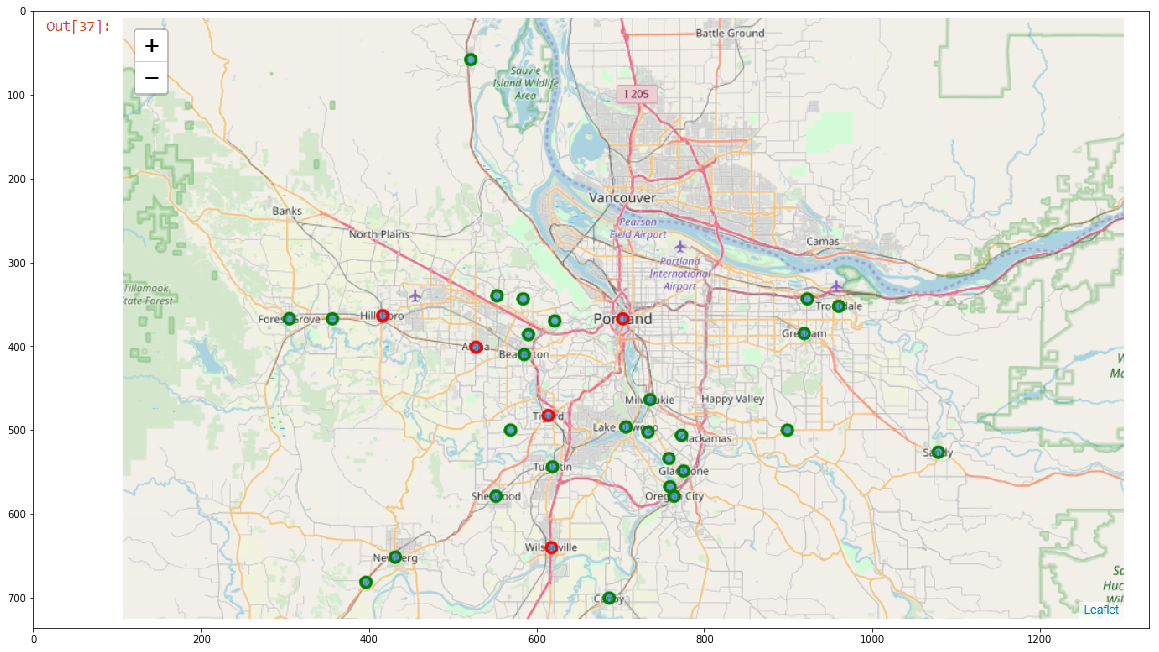

In [39]:
# Showing the map picture through PNG due to the limitation of jupyter notebook not rendering folium map correctly.
import matplotlib.image as image
import matplotlib.pyplot as plt

img = image.imread('Costco-Store-Prediction-Oregon.PNG')
plt.figure(figsize=(20, 15))
plt.imshow(img)

In the above graph, the RED color circle indicating existing Costso locations while the GREEN color circle indicates new future locations for Costso Warehouse.

The good news are that all existing Costco warehouse locations in Oregon state are correctly predicted by the classifier. That's 100% accuracy! It gives confidences that other locations predicted by the classifier have meaningful considersations. 


## Completing all State Predictions in U.S.

Due to time limits, I have only completed the Prediction for one state (Oregon State). In order to complete the predictions for all states in U.S., repeat the above steps to first exclude that specific state during training, then run the predict function of the classifier to predict that state.

Once all states are predicts, the total cities are the full potentials of what Costco should or could open their warehouse in. That indicates the Costco Stores Growth Potentials.


## Future Considerations

Due to the limitation of the project schedule as well as the availability of the data sources, this project only focuses on limited set of features for city predictions. There are multiple areas for future enhancement:

### 1. Additional City Information

More city information would be very helpful to add as features to assist the classification analysis. For example, the property or housing price in the area, crime rate for safety, number of children on average family, etc.

### 2. Costco Warehouse Financial Information

When more Costco warehouse financial information are available, it would help to make multiple classification more accurate, for example, the average sales or revenue per location, the type of Costco warehouse location as gorcercy, gas station, vision or other. 

### 3. Different Categorization Strategy

For Categories = 2 or 3, there are no enough data for the training set. In the future, we need to search for more data. Another categorization strategy could be to leverage the Costco store sales performance.
